# DSCI 617 – Homework 06.
**Felix Asare**

In [0]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
 
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
 
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier
from pyspark.ml import Pipeline
 
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
 
spark = SparkSession.builder.getOrCreate()

## Problem 1: Load Stroke Data

In [0]:
# Create Schema
stroke_df = (
    spark.read
    .option("delimiter", ",")
    .option("header", True)
    .schema(
        'gender STRING, age DOUBLE, hypertension INT, heart_disease INT, ever_married STRING, work_type STRING, residence_type STRING, avg_glucose_level DOUBLE, bmi DOUBLE, smoking_status STRING, stroke INT'
    )
    .csv('/FileStore/tables/stroke_data.csv')
)

stroke_df.printSchema()


root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [0]:
# First 10 rows
stroke_df.show(10)

+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|Female|13.0|           0|            0|          No|      Private|         Urban|            77.63|31.7|   never smoked|     0|
|  Male|10.0|           0|            0|          No|        Child|         Rural|            84.02|18.7|   never smoked|     0|
|Female|82.0|           0|            1|         Yes|Self-employed|         Rural|             88.6|32.5|        Unknown|     0|
|Female| 3.0|           0|            0|          No|        Child|         Urban|            57.33|16.8|        Unknown|     0|
|Female|65.0|           0|            0|         Yes|Self-employed|         Rural|           220.

In [0]:
# Number of Observations
N = stroke_df.count()
print(N)

6853


In [0]:
# Proportion of Observations
stroke_df.select('stroke').groupBy('stroke')\
    .agg(
        expr('count(*) as count'),
        expr(f'ROUND(COUNT(*)/{N}, 4) as prop')
    ).show()

+------+-----+------+
|stroke|count|  prop|
+------+-----+------+
|     1| 1992|0.2907|
|     0| 4861|0.7093|
+------+-----+------+



## Problem 2: Preprocessing

In [0]:
# Seperating Numeric and Categorical Columns
num_features = ['age', 'avg_glucose_level', 'bmi']
cat_features = [c for c in stroke_df.columns[:-1] if c not in num_features]


#Integer encoding and One-Hot encoding
ix_features = [c + '_ix' for c in cat_features]
vec_features = [c + '_vec' for c in cat_features]

# String Indexing
label_indexer = StringIndexer(inputCol='stroke', outputCol='label')
feature_indexer = StringIndexer(inputCols=cat_features, outputCols=ix_features)
# One-Hot Encoding
encoder = OneHotEncoder(inputCols=ix_features, outputCols=vec_features, dropLast=False)
# Vector Assembler
assember = VectorAssembler(inputCols=num_features+vec_features, outputCol='features')


In [0]:
# Create pipeline
pipeline = Pipeline(stages=[label_indexer, feature_indexer, encoder, assember]).fit(stroke_df)
train = pipeline.transform(stroke_df)
#Persist train
train.persist()

DataFrame[gender: string, age: double, hypertension: int, heart_disease: int, ever_married: string, work_type: string, residence_type: string, avg_glucose_level: double, bmi: double, smoking_status: string, stroke: int, label: double, gender_ix: double, hypertension_ix: double, heart_disease_ix: double, ever_married_ix: double, work_type_ix: double, residence_type_ix: double, smoking_status_ix: double, gender_vec: vector, hypertension_vec: vector, heart_disease_vec: vector, ever_married_vec: vector, work_type_vec: vector, residence_type_vec: vector, smoking_status_vec: vector, features: vector]

## Problem 3: Hyperparameter Tuning for Logistic Regression

In [0]:
# Accuracy matrix
accuracy_eval = MulticlassClassificationEvaluator(
    predictionCol='prediction', labelCol='label', metricName='accuracy')

# Create Logistic Regression class
logreg = LogisticRegression(labelCol='label', featuresCol='features')
logreg_model = logreg.fit(train)

# Create hyperparameter grid
param_grid = (
    ParamGridBuilder()
            .addGrid(logreg.regParam, [0.0001, 0.001, 0.01, 0.1, 1])
            .addGrid(logreg.elasticNetParam, [0, 0.5, 1])
).build()

# Create cross validator
cv = CrossValidator(estimator=logreg, estimatorParamMaps=param_grid, evaluator=accuracy_eval, numFolds=5, seed=1)
cv_model = cv.fit(train)


In [0]:
#identify optimal model
opt_model = cv_model.bestModel
 
opt_regParam = opt_model.getRegParam()
opt_enetParam = opt_model.getElasticNetParam()
 
print('Max CV Score:  ', round(max(cv_model.avgMetrics),4))
print('Optimal Lambda:', opt_regParam)
print('Optimal Alpha: ', opt_enetParam)

Max CV Score:   0.774
Optimal Lambda: 0.01
Optimal Alpha:  0.0


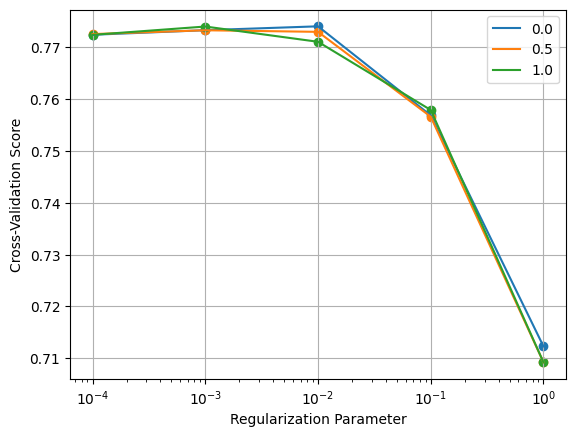

(Text(0.5, 24.0, 'Regularization Parameter'),
 Text(24.00000000000002, 0.5, 'Cross-Validation Score'),
 None)

In [0]:
# plot cross validation result
model_params = cv_model.getEstimatorParamMaps()
lr_cv_summary_list = []
for param_set, acc in zip(model_params, cv_model.avgMetrics):
    new_set = list(param_set.values()) + [acc]
    lr_cv_summary_list.append(new_set)

cv_summary = pd.DataFrame(lr_cv_summary_list, 
                          columns=['reg_param', 'enet_param', 'acc'])

for en in cv_summary.enet_param.unique():
    sel = cv_summary.enet_param == en
    plt.plot(cv_summary.reg_param[sel], cv_summary.acc[sel], label=en)
    plt.scatter(cv_summary.reg_param[sel], cv_summary.acc[sel])

plt.legend()
plt.xscale('log')
plt.grid()
plt.xlabel('Regularization Parameter'), plt.ylabel('Cross-Validation Score'), plt.show()

            

## Problem 4: Training Predictions

In [0]:
# Generate predictions
train_pred = opt_model.transform(train)
train_pred.select('probability', 'prediction', 'label').show(10, truncate=False)

+-----------------------------------------+----------+-----+
|probability                              |prediction|label|
+-----------------------------------------+----------+-----+
|[0.9747140890756103,0.0252859109243897]  |0.0       |0.0  |
|[0.9872318011645983,0.0127681988354017]  |0.0       |0.0  |
|[0.29265947121077845,0.7073405287892216] |1.0       |0.0  |
|[0.9908447681537692,0.009155231846230794]|0.0       |0.0  |
|[0.5429884231739687,0.45701157682603133] |0.0       |0.0  |
|[0.7013317009925937,0.2986682990074063]  |0.0       |1.0  |
|[0.6793380107028687,0.3206619892971313]  |0.0       |1.0  |
|[0.9522140166448959,0.04778598335510409] |0.0       |0.0  |
|[0.4894259348203679,0.5105740651796321]  |1.0       |0.0  |
|[0.4749500136675296,0.5250499863324705]  |1.0       |0.0  |
+-----------------------------------------+----------+-----+
only showing top 10 rows



In [0]:
# Filter rows where predictions is not equal to label
train_pred.filter(train_pred.prediction != train_pred.label).select('probability', 'prediction', 'stroke').show(10, truncate=False)

+----------------------------------------+----------+------+
|probability                             |prediction|stroke|
+----------------------------------------+----------+------+
|[0.29265947121077845,0.7073405287892216]|1.0       |0     |
|[0.7013317009925937,0.2986682990074063] |0.0       |1     |
|[0.6793380107028687,0.3206619892971313] |0.0       |1     |
|[0.4894259348203679,0.5105740651796321] |1.0       |0     |
|[0.4749500136675296,0.5250499863324705] |1.0       |0     |
|[0.3106588756065039,0.6893411243934962] |1.0       |0     |
|[0.5111778916185864,0.4888221083814136] |0.0       |1     |
|[0.5394169187722885,0.4605830812277115] |0.0       |1     |
|[0.5501176180010955,0.4498823819989045] |0.0       |1     |
|[0.6985579547487483,0.30144204525125173]|0.0       |1     |
+----------------------------------------+----------+------+
only showing top 10 rows



- The highest probability observed for an incorrect answer is [0.29265947121077845,0.7073405287892216], 0.7073
- The lowest probability observed for an incorrect answer is [0.4894259348203679, 0.5105740651796321], 0.5106

## Problem 5: Classification Metrics

In [0]:
# RDD of prediction/label pair
pred_and_labels = train_pred.rdd.map(lambda x:(x['prediction'],float(x['stroke'])))

# Create a MulticlassMetrics object
from pyspark.mllib.evaluation import MulticlassMetrics
metrics = MulticlassMetrics(pred_and_labels)
print(metrics.accuracy)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


0.776010506347585


In [0]:
# Extract Confusion Matrix
conf_matrix = metrics.confusionMatrix().toArray()

# Display Confusion Matrix in DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=[0, 1], columns=[0, 1])

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix_df)



Confusion Matrix:
        0      1
0  4323.0  538.0
1   997.0  995.0


In [0]:
# Calculate precision and recall for label 0
precision_0 = metrics.precision(0.0)
recall_0 = metrics.recall(0.0)

# Calculate precision and recall for label 1
precision_1 = metrics.precision(1.0)
recall_1 = metrics.recall(1.0)

# Display the results rounded to 4 decimal places
print(f"{'Label':<10}{'Precision':<10}      {'Recall'}")
print(f"{'-'*32}")
print(f"{0:<10}{precision_0:.4f}{' ' * 10}{recall_0:.4f}")
print(f"{1:<10}{precision_1:.4f}{' ' * 10}{recall_1:.4f}")


Label     Precision       Recall
--------------------------------
0         0.8126          0.8893
1         0.6491          0.4995


## Problem 6: Applying the Model to New Data

In [0]:
# Create new data
schema = """
    gender STRING, 
    age DOUBLE, 
    hypertension INT, 
    heart_disease INT, 
    ever_married STRING, 
    work_type STRING, 
    residence_type STRING, 
    avg_glucose_level DOUBLE, 
    bmi DOUBLE, 
    smoking_status STRING
"""

# Data for the new DataFrame
data = [
    ('Female', 42.0, 1, 0, 'No', 'Private', 'Urban', 182.1, 26.8, 'smokes'),
    ('Female', 64.0, 1, 1, 'Yes', 'Self-employed', 'Rural', 171.5, 32.5, 'formerly smoked'),
    ('Male', 37.0, 0, 0, 'Yes', 'Private', 'Rural', 79.2, 18.4, 'Unknown'),
    ('Male', 72.0, 0, 1, 'No', 'Govt_job', 'Urban', 125.7, 19.4, 'never smoked')
]

# Create the DataFrame using the DDL schema
new_data = spark.createDataFrame(data, schema=schema)

# Display the new DataFrame
new_data.show()



+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
|gender| age|hypertension|heart_disease|ever_married|    work_type|residence_type|avg_glucose_level| bmi| smoking_status|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+
|Female|42.0|           1|            0|          No|      Private|         Urban|            182.1|26.8|         smokes|
|Female|64.0|           1|            1|         Yes|Self-employed|         Rural|            171.5|32.5|formerly smoked|
|  Male|37.0|           0|            0|         Yes|      Private|         Rural|             79.2|18.4|        Unknown|
|  Male|72.0|           0|            1|          No|     Govt_job|         Urban|            125.7|19.4|   never smoked|
+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+



In [0]:
# Process Data
processed_new_data = pipeline.transform(new_data)

# Step 2: Apply the trained cross-validated model to the processed data
new_data_predictions = cv_model.transform(processed_new_data)

# Step 3: Display the probability and prediction columns
new_data_predictions.select('probability', 'prediction').show(truncate=False)

+----------------------------------------+----------+
|probability                             |prediction|
+----------------------------------------+----------+
|[0.7054270074784814,0.2945729925215186] |0.0       |
|[0.2757821232703251,0.724217876729675]  |1.0       |
|[0.9126460874571503,0.08735391254284974]|0.0       |
|[0.40098498644373304,0.599015013556267] |1.0       |
+----------------------------------------+----------+

